In [1]:
import warnings
warnings.simplefilter(action="ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import xgboost as xgb
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,roc_auc_score,roc_curve
from sklearn.inspection import PartialDependenceDisplay, permutation_importance

plt.rcParams.update({'figure.figsize':(12,6)})
plt.rcParams.update({'font.size':20})

In [2]:
fraud = pd.read_csv("Fraud_Data.csv")

In [3]:
fraud

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
...,...,...,...,...,...,...,...,...,...,...,...
151107,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3.451155e+09,1
151108,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2.439047e+09,0
151109,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2.748471e+09,0
151110,207709,2015-07-09 20:06:07,2015-09-07 09:34:46,46,CMCXFGRHYSTVJ,SEO,Chrome,M,37,3.601175e+09,0


In [4]:
len(fraud['user_id'].unique()) == len(fraud)

True

# Identify country for each user

In [5]:
ip = pd.read_csv("IpAddress_to_Country.csv")
ip

,lower_bound_ip_address,upper_bound_ip_address,country
0,1.677722e+07,16777471,Australia
1,1.677747e+07,16777727,China
2,1.677773e+07,16778239,China
3,1.677824e+07,16779263,Australia
4,1.677926e+07,16781311,China
...,...,...,...
138841,3.758092e+09,3758093311,Hong Kong
138842,3.758093e+09,3758094335,India
138843,3.758095e+09,3758095871,China
138844,3.758096e+09,3758096127,Singapore


In [6]:
country = []
for i in range(len(fraud)):
    ipa = fraud['ip_address'][i]
    c = ip.loc[(ip['lower_bound_ip_address'] < ipa) & (ip['upper_bound_ip_address'] > ipa),'country']
    if len(c) == 1:
        country.append(c.values[0])
    else:
        country.append('NA')
fraud['country'] = country

In [7]:
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


# Feature Engineering

In [8]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
 11  country         151112 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 13.8+ MB


In [9]:
# Time difference between sign-up time and purchase time
fraud['signup_time'] = pd.to_datetime(fraud['signup_time'])
fraud['purchase_time'] = pd.to_datetime(fraud['purchase_time'])
fraud['interval'] = fraud['purchase_time'] - fraud['signup_time']
fraud['interval'] = fraud['interval'].apply(lambda x: x.seconds)

In [10]:
# check for each device id how many different users had it
fraud['device_id_count'] = fraud.groupby('device_id').user_id.transform("count")

In [11]:
#check for each ip address how many different users had it
fraud['ip_address_count'] = fraud.groupby('ip_address').user_id.transform("count")

In [12]:
#day of the week
fraud['purchase_time_wd'] = fraud['purchase_time'].dt.dayofweek

In [13]:
#week of the yr
fraud['purchase_time_wy'] = fraud['purchase_time'].dt.week

In [14]:
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,interval,device_id_count,ip_address_count,purchase_time_wd,purchase_time_wy
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1,1,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1,2,37


# Exploratory Data Analysis

In [15]:
print('Fraud rate is '+ str(round(np.mean(fraud['class']) * 100, 2)) + '%.')

Fraud rate is 9.36%.


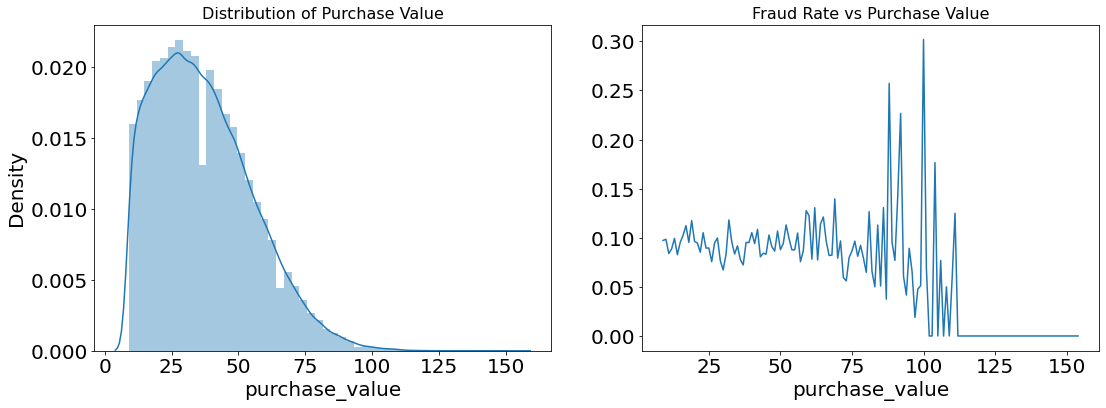

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(fraud['purchase_value'],bins=50, kde=True, ax=ax[0])
ax[0].set_title('Distribution of Purchase Value', fontsize=16)
fraud.groupby('purchase_value')['class'].mean().plot(ax=ax[1])
ax[1].set_title('Fraud Rate vs Purchase Value', fontsize=16)
plt.show()

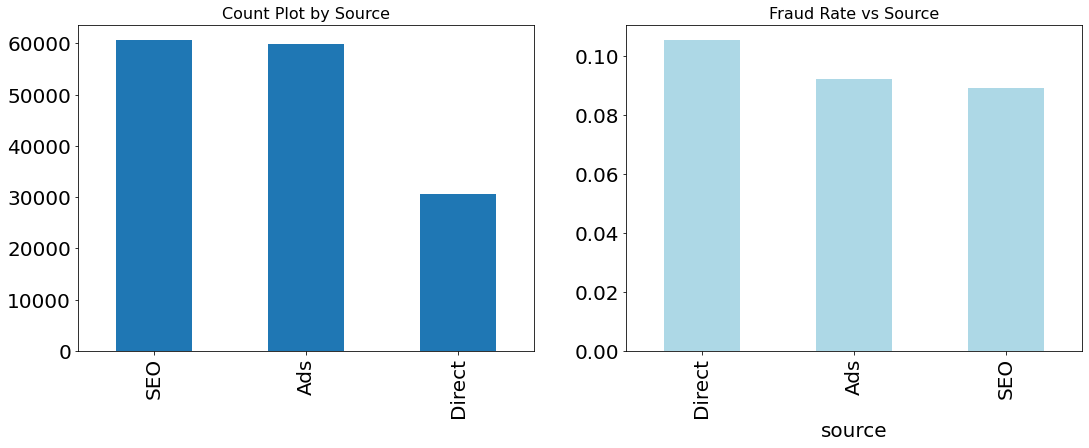

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
fraud['source'].value_counts().plot(kind='bar',ax=ax[0])
ax[0].set_title('Count Plot by Source', fontsize=16)
fraud.groupby('source')['class'].mean().sort_values(ascending=False).plot(kind='bar',ax=ax[1],color="lightblue")
ax[1].set_title('Fraud Rate vs Source', fontsize=16)
plt.show()

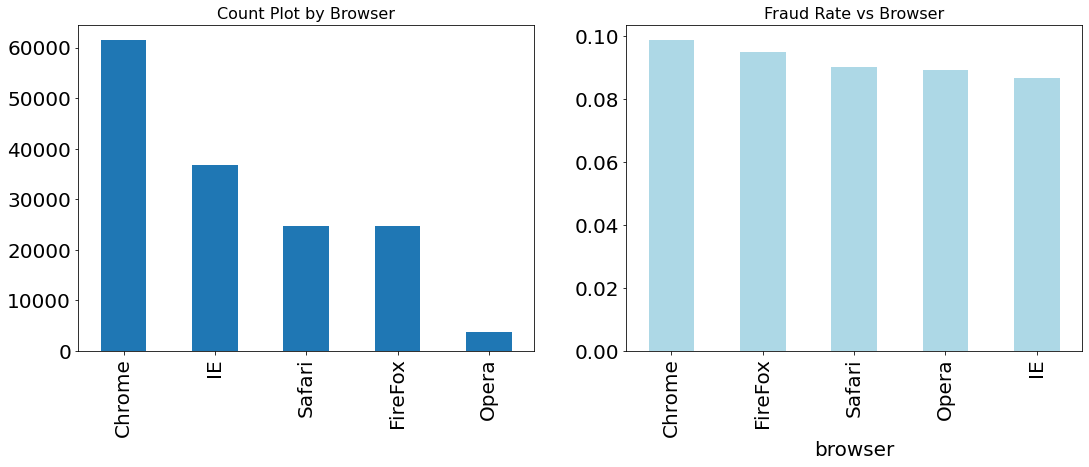

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
fraud['browser'].value_counts().plot(kind='bar',ax=ax[0])
ax[0].set_title('Count Plot by Browser', fontsize=16)
fraud.groupby('browser')['class'].mean().sort_values(ascending=False).plot(kind='bar',ax=ax[1],color="lightblue")
ax[1].set_title('Fraud Rate vs Browser', fontsize=16)
plt.show()

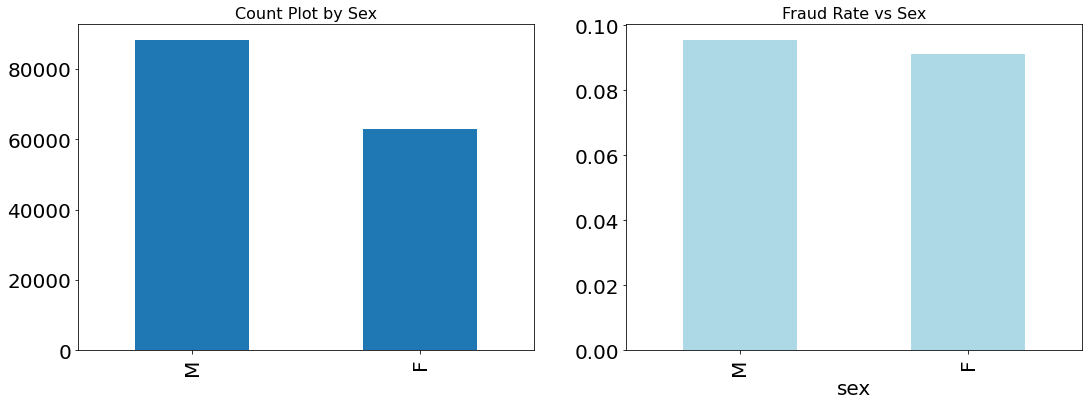

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
fraud['sex'].value_counts().plot(kind='bar',ax=ax[0])
ax[0].set_title('Count Plot by Sex', fontsize=16)
fraud.groupby('sex')['class'].mean().sort_values(ascending=False).plot(kind='bar',ax=ax[1],color="lightblue")
ax[1].set_title('Fraud Rate vs Sex', fontsize=16)
plt.show()

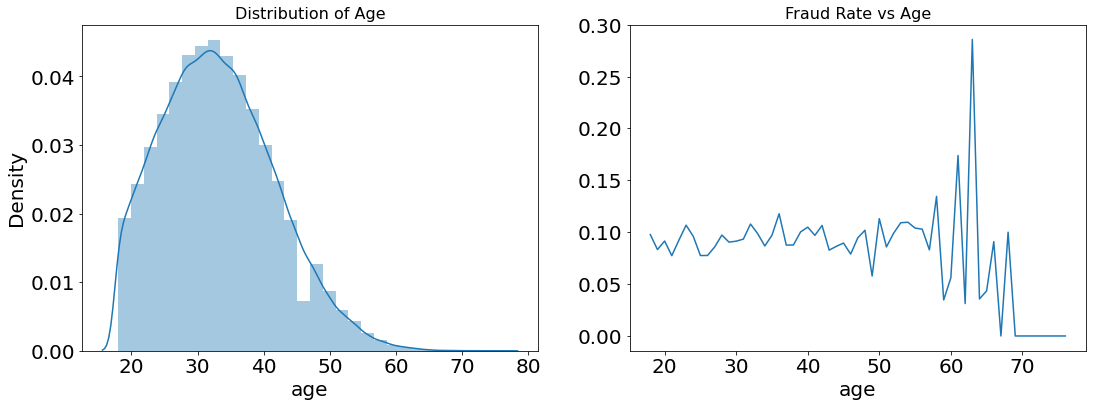

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(fraud['age'],bins=30, kde=True, ax=ax[0])
ax[0].set_title('Distribution of Age', fontsize=16)
fraud.groupby('age')['class'].mean().plot(ax=ax[1])
ax[1].set_title('Fraud Rate vs Age', fontsize=16)
plt.show()

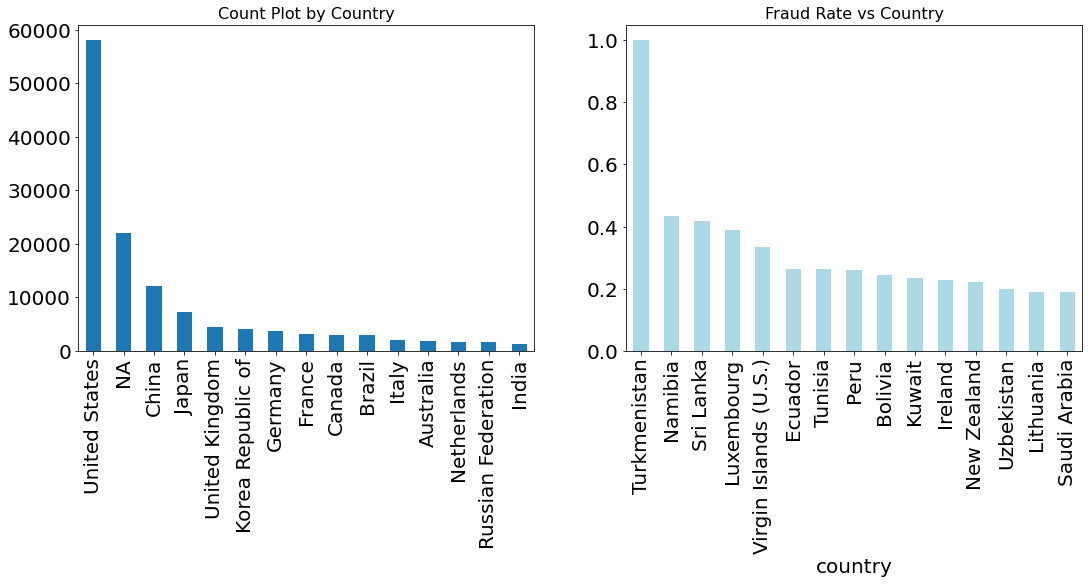

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
fraud['country'].value_counts()[:15].plot(kind='bar',ax=ax[0])
ax[0].set_title('Count Plot by Country', fontsize=16)
fraud.groupby('country')['class'].mean().sort_values(ascending=False)[:15].plot(kind='bar',ax=ax[1],color="lightblue")
ax[1].set_title('Fraud Rate vs Country', fontsize=16)
#plt.tight_layout()
plt.show()

In [22]:
fraud[fraud['country'] == 'Turkmenistan']

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,interval,device_id_count,ip_address_count,purchase_time_wd,purchase_time_wy
2420,138998,2015-02-27 14:39:08,2015-03-31 12:12:40,37,RSEQYZOIJLVPL,SEO,FireFox,F,29,1.583788e+09,1,Turkmenistan,77612,2,1,1,14


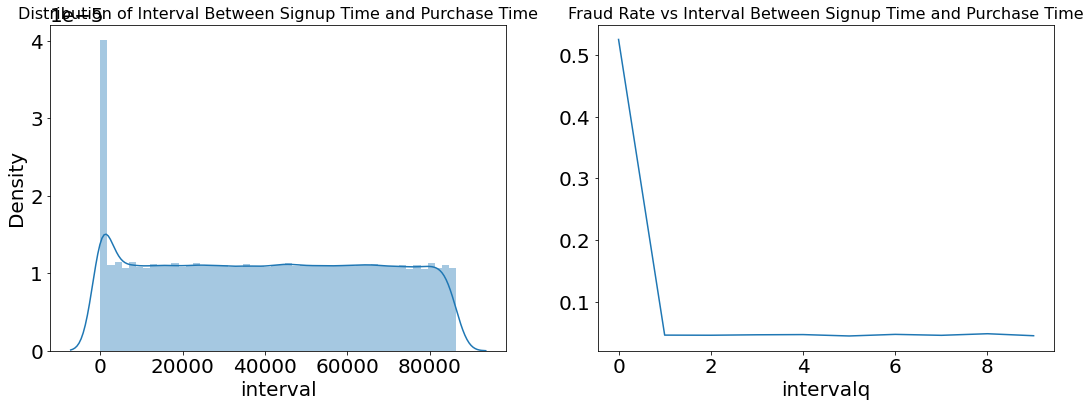

In [23]:
fraud['intervalq'] = pd.qcut(fraud['interval'], 10, labels=False)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(fraud['interval'], kde=True, ax=ax[0])
ax[0].set_title('Distribution of Interval Between Signup Time and Purchase Time', fontsize=16)
fraud.groupby('intervalq')['class'].mean().plot(ax=ax[1])
ax[1].set_title('Fraud Rate vs Interval Between Signup Time and Purchase Time', fontsize=16)
plt.show()

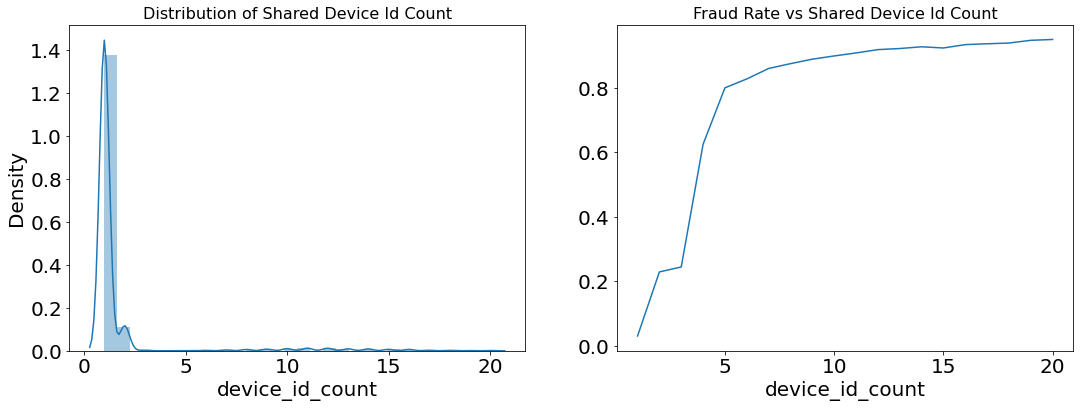

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(fraud['device_id_count'],bins=30, kde=True, ax=ax[0])
ax[0].set_title('Distribution of Shared Device Id Count', fontsize=16)
fraud.groupby('device_id_count')['class'].mean().plot(ax=ax[1])
ax[1].set_title('Fraud Rate vs Shared Device Id Count', fontsize=16)
plt.show()

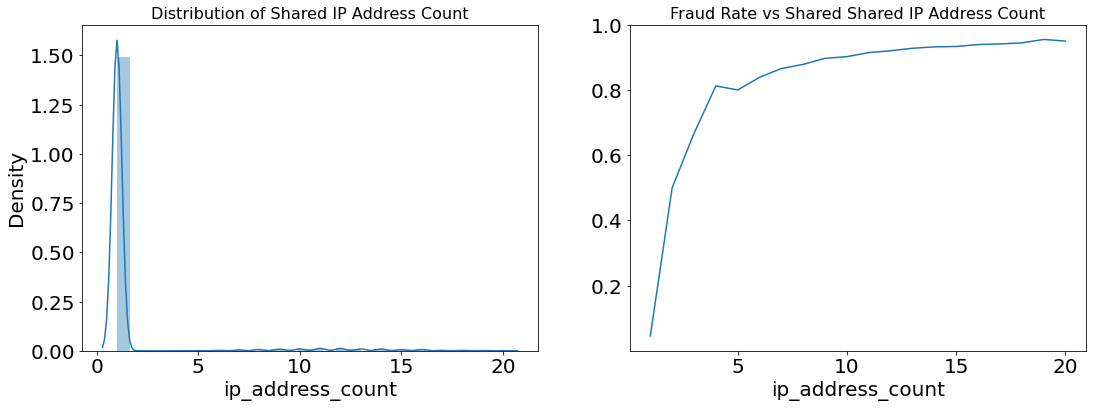

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(fraud['ip_address_count'],bins=30, kde=True, ax=ax[0])
ax[0].set_title('Distribution of Shared IP Address Count', fontsize=16)
fraud.groupby('ip_address_count')['class'].mean().plot(ax=ax[1])
ax[1].set_title('Fraud Rate vs Shared Shared IP Address Count', fontsize=16)
plt.show()

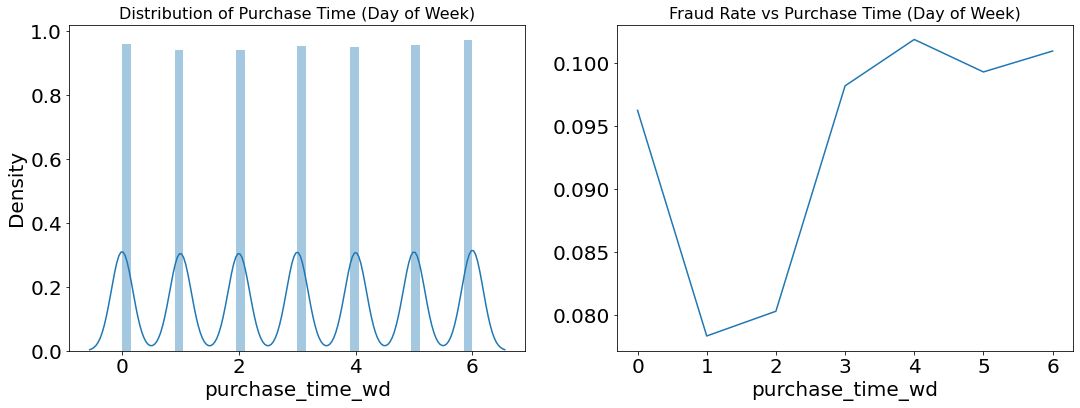

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(fraud['purchase_time_wd'],ax=ax[0])
ax[0].set_title('Distribution of Purchase Time (Day of Week)', fontsize=16)
fraud.groupby('purchase_time_wd')['class'].mean().plot(ax=ax[1])
ax[1].set_title('Fraud Rate vs Purchase Time (Day of Week)', fontsize=16)
plt.show()

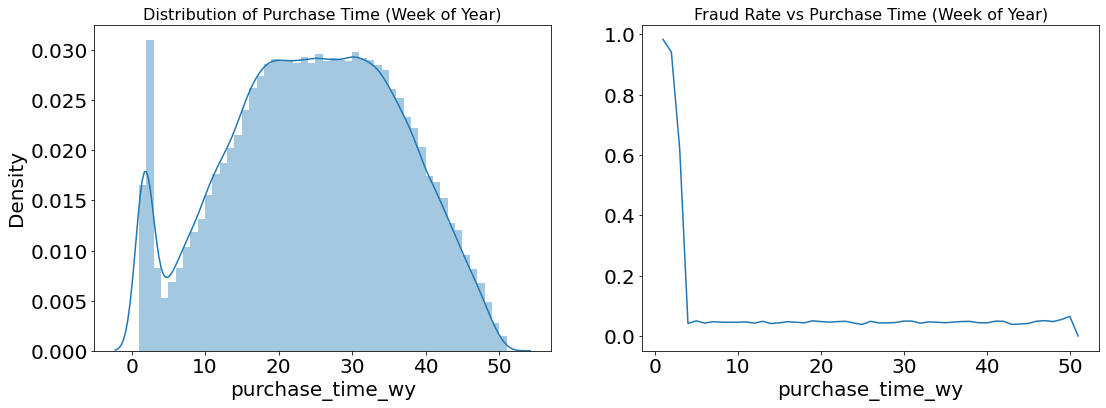

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(fraud['purchase_time_wy'],ax=ax[0])
ax[0].set_title('Distribution of Purchase Time (Week of Year)', fontsize=16)
fraud.groupby('purchase_time_wy')['class'].mean().plot(ax=ax[1])
ax[1].set_title('Fraud Rate vs Purchase Time (Week of Year)', fontsize=16)
plt.show()

<AxesSubplot:>

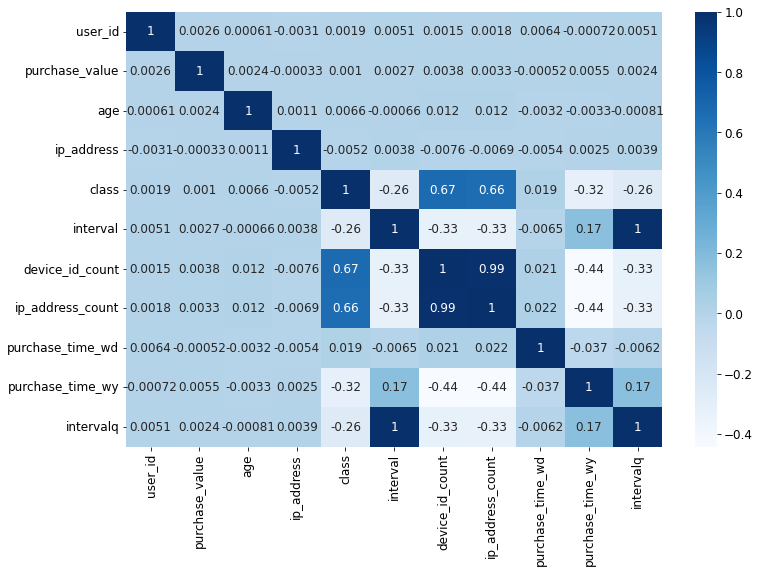

In [28]:
plt.rcParams.update({'figure.figsize':(12,8)})
plt.rcParams.update({'font.size':12})
corr_plot = fraud.corr()
sns.heatmap(corr_plot, annot = True, xticklabels = True, yticklabels = True,cmap = "Blues")

1. The distribution of purchase values peaks at 25 dollars, and very few orders are great than 80 dollars. However, fraud transactions tend to have a high order value, larger than 80 dollars.
2. There are fewer customers coming to the site directly than from ads and SEO, however, the fraud rate of orders coming from the direct source is slightly higher than the others.
3. This e-commerce site might be a US site as a majority of orders are from United States. However, countries with higher fraud rates are mostly small countries. Also, we notice that the fraud rate of country Turkmenistan is extremely high, it can be explained by sample size of 1.
4. Orders placed immediately after signup are very likely to be fruads. 
5. Orders with device or IP address shared with 5 accounts are weird, and can be identifies as frauds.
6. Frauds tend to take place at the beginning of a year.
7. Shared IP address count is highly correlated with shared device ID count.

# Machine Learning (XGBoost)

In [29]:
X = fraud.copy()
X = X.drop(columns=['user_id','signup_time', 'purchase_time','device_id','ip_address','class','country'])
X = pd.get_dummies(X, drop_first=True)
y = fraud['class'].copy()

In [30]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=123)

In [31]:
clf = xgb.XGBClassifier(
    max_depth=3,
    n_estimators=10,
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="auc",
    random_state=1234,
).fit(X_train, y_train, verbose=True)

In [31]:
# param_grid = {
#     "max_depth": [1,2,3,4],
#     "n_estimators": [10,20,30],
# }
# scoring = {"AUC": "roc_auc"}


# clf_cv = GridSearchCV(
#     clf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=10
# ).fit(X_train, y_train)

# print(clf_cv.best_params_)
# print(clf_cv.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'max_depth': 3, 'n_estimators': 10}
0.8467779908072227


In [32]:
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27323
           1       1.00      0.53      0.69      2900

    accuracy                           0.95     30223
   macro avg       0.98      0.77      0.83     30223
weighted avg       0.96      0.95      0.95     30223



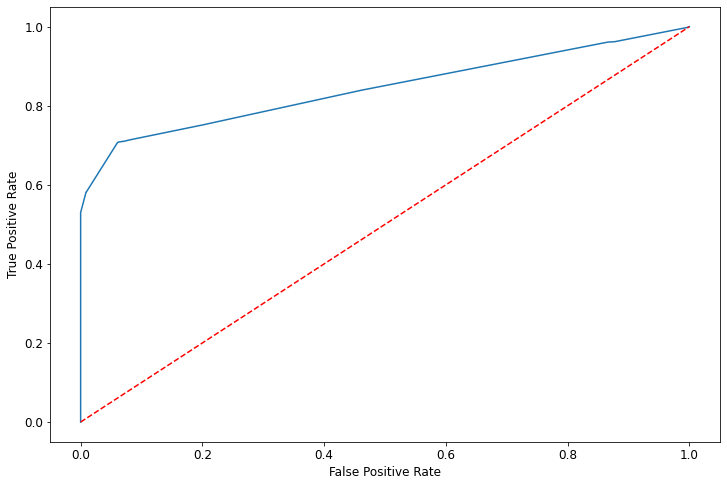

In [33]:
y_pred_proba = clf.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [34]:
auc_df = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'threshold':threshold})
auc_df[auc_df['fpr'] == 0]

,fpr,tpr,threshold
0,0.0,0.000000,1.977615
1,0.0,0.529655,0.977615
2,0.0,0.530000,0.849344


In [35]:
auc_df[(auc_df['tpr'] > 0.75) & (auc_df['tpr'] < 0.8)]

,fpr,tpr,threshold
30,0.201076,0.751724,0.049509
31,0.251217,0.768621,0.049294


Based on the ROC, we can see the trader-off between maximizing true positive rate and minimizing false positive rate. If we care about minimizing false positive rate, we would choose a cut-off that would give us true positive rate of ~0.5 and false positive rate almost zero. However, if we care about maximizing true positive, we will have to decrease the cut-off. This way we will classify more events as “1”: some will be true ones (so true positive goes up) and many, unfortunately, will be false ones (so false positive will also go up). 

Considering the cost of true positive is not catching a fraud transaction and losing money and the cost of false positive is trivial as it may only add more steps before transaction process, so I would prefer prioritizing maximizing true positive.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

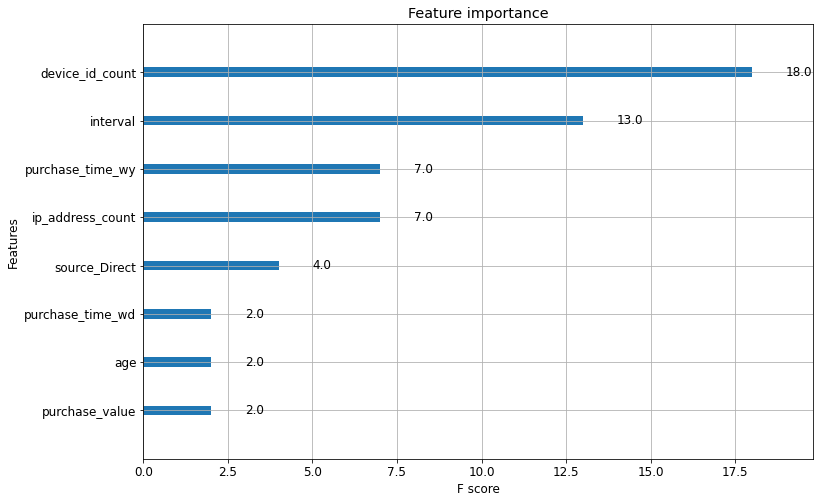

In [36]:
xgb.plot_importance(clf)

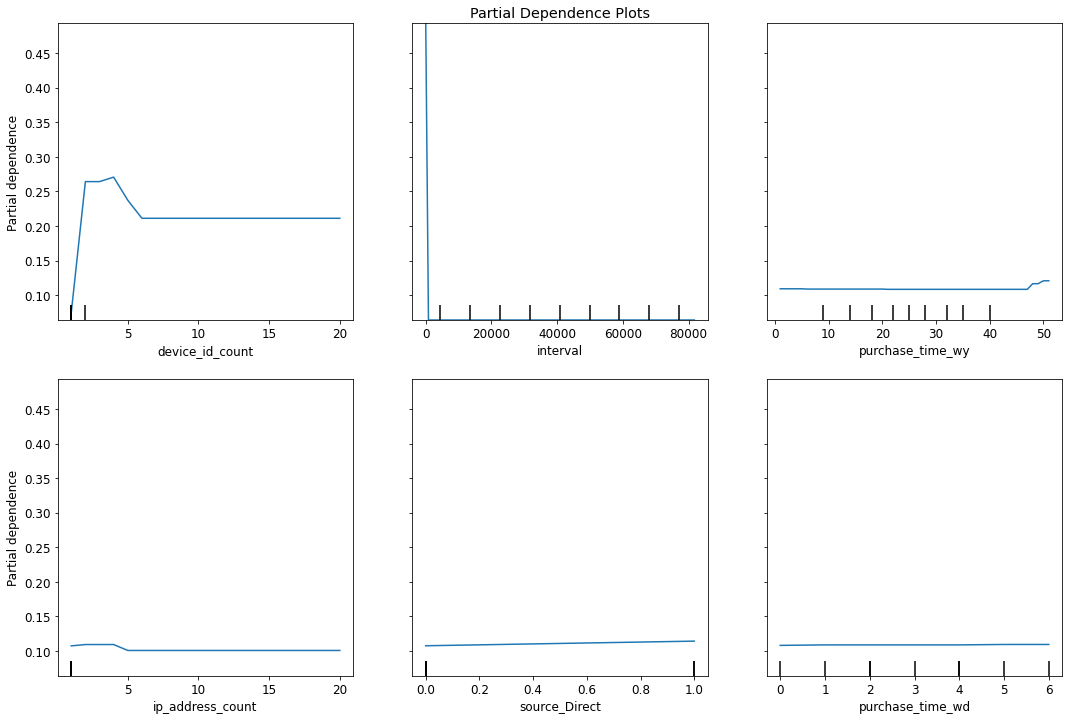

In [37]:
columns = ['device_id_count','interval','purchase_time_wy','ip_address_count','source_Direct','purchase_time_wd']
fig, ax = plt.subplots(figsize=(18,12))
ax.set_title("Partial Dependence Plots")
fig = PartialDependenceDisplay.from_estimator(clf, X, columns, ax=ax)

To better understand, we fit a simple decision tree and plot it.

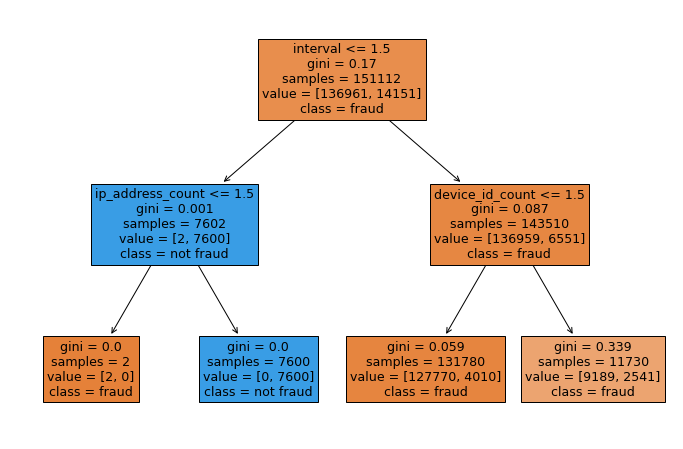

In [38]:
clf = tree.DecisionTreeClassifier(max_depth=2).fit(X, y)
fig = tree.plot_tree(clf, feature_names=X.columns, class_names=["fraud", "not fraud"], filled=True)

# Conclusions 

Main takeaways from the model:
1. If a customer places an order immediately after signing up and skips the selection process, there is high probability that it's a fraud.
2. When a deivce is shared by several user accounts, the model will suspect that some one is conducting a fraud by changing different accounts to avoid fraud detection algorithm. Same for IP address.
3. The model will pay more attention to the orders placed during the first 8 weeks of the year.
4. It makes sense that frauds come to the site by directly typing the site address on the browser with a clear and illegal goal rather than from any type of advertisment.

We now have a model that assigns to each user a probability of committing a fraud. We will design a product that can be used live to predict in real time.

1. If predicted fraud probability < threshold 1, the user has the normal experience (the high majority should fall here)
2. If X <= predicted fraud probability < threshold 2 (so the user is at risk, but not too much), we can create an additional verification step, like verify your phone number via a code sent by SMS or log in via Facebook.
3. If predicted fraud probability >= threshold 2 (so here is really likely the user is trying to commit a fraud), you can tell the user his session has been put on hold, send this user info to someone who reviews it manually and either blocks the user or decides it is not a fraud so the session is resumed.